A while back I got a Master Lock "speed dial" pad lock. The padlock has a central nub that you push up/down/left/right in the correct sequence to unlock the lock. Like most locks you can set this sequence to a sequence of your choice. However, unlike most locks, you can set this pass sequence to be of any length! This begs the question how many different combinations does this lock allow? And if you were so inclined what would be the fastest possible way to crack its pass code?

![lock_teaser_image](../images/real_world_loopy_lock_teaser.jpg)

<!-- TEASER_END -->

The question of how many pass codes a lock has isn't usually hard to answer. For a regular 40 number spinning dial padlock the pass sequence has length 3 and each of the three numbers are independently chosen from the others so the total number of possible combinations is $40^3=64,000$ easy peasy. But how many combinations are possible with this weird lock which allows arbitrary length pass sequences? In some sense there are infinitely many since there are infinitely many possible input sequences. But logically there can only be a finite number of minimum length combinations that can open the lock. 

The mechanism inside the lock is of finite complexity and so the lock can only have a finite number of possible internal states. Lets call the number of accessible states $N$. Then there exists some maximum pass sequence length past which we are guaranteed to begin seeing the same internal lock states over again. Or in other words by the pigeon hole principle if the number of accessible lock states is smaller than the number of pass sequences of some length $N \leq 4^{L}$ then it is a guarantee that there will be multiple pass sequences of length $L$ or less which will be interchangeable with each other.

If the number of internal states of this lock is in the trillions then we might expect to need pass code sequences of length 10 or so before expecting any pass code collisions to begin (<a href=https://en.wikipedia.org/wiki/Birthday_problem>birthday paradox</a> reasoning). But it seems that a much more likely estimate is that the lock mechanism complexity is comparable to that of the standard combination locks and has a number of internal states which is on the order of a few tens of thousands. In which case we might expect to begin seeing pass code collisions for much shorter codes. Pass codes of just length 4 or 5 might happen to have even shorter codes which still open the lock!

This is as far as I would have been able to get on my own since I don't really own any tools and probably wouldn't want to tear open a lock to take a look at how it works even if I did. The instruction sheet that came with the lock labels it as the 1500iD and after a little web search I found this wonderful analysis of the lock internals by Michael Huebler.

<a href=https://toool.nl/images/e/e5/The_New_Master_Lock_Combination_Padlock_V2.0.pdf>https://toool.nl/images/e/e5/The_New_Master_Lock_Combination_Padlock_V2.0.pdf</a>

It turns out that the internal state dynamics of the lock can be summarized like so;

There are 4 combination disks inside, one for each of the four directions with each disk having 15 possible operating positions. When you push in a direction the combination disk in that direction and to either side of it rotate an amount determined by the current rotational state of the disks. The disk straight on rotates to the next greatest position which is a multiple of three and the disks to either side of it rotate to the next greatest index of the form of 3k+1 and 3k-1. I've attempted to express the dynamics by the following python code for calculating the positions of the internal combination disks given a code sequence of moves.

In [285]:
from functools import lru_cache

def counterclockwise_adjustment(n):
    modulus = n % 3
    if modulus == 2:
        return (n + 3) % 15 #stays modulus class 2
    else:
        k = n//3
        return (3*k+2) % 15 #increase up to next modulus class 2

def direct_adjustment(n):
    return 3*((n+3)//3) % 15 #increase to the next multiple of 3

def clockwise_adjustment(n):
    modulus = n % 3
    if modulus == 1:
        return (n + 3) % 15 #stays modulus class 1
    elif modulus == 0:
        return (n+1) % 15 #next modulus class 1
    elif modulus == 2:
        return (n+2) % 15

@lru_cache(2**15) #cache the transitions for slightly faster calculations
def advance_lock_state(
    tumbler_states,
    move_direction,
):
    #make the state mutable so we can assign the changes into it.
    tumbler_states = list(tumbler_states)
    
    idx = (move_direction - 1) % 4
    tumbler_states[idx] = counterclockwise_adjustment(tumbler_states[idx])
    
    idx = move_direction
    tumbler_states[idx] = direct_adjustment(tumbler_states[idx])
    
    idx = (move_direction + 1) % 4
    tumbler_states[idx] = clockwise_adjustment(tumbler_states[idx])
    
    #return an immutable lock state so we can use it as a dictionary key
    return tuple(tumbler_states)

def code_to_state(code_seq, start_state=None):
    if start_state is None:
        cstate = (0, 0, 0, 0)
    else:
        cstate = start_state
    for direction in code_seq:
        cstate = advance_lock_state(cstate, direction)
    return cstate

In [286]:
[direct_adjustment(i) for i in range(15)]

[3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 0, 0, 0]

In [287]:
[counterclockwise_adjustment(i) for i in range(15)]

[2, 2, 5, 5, 5, 8, 8, 8, 11, 11, 11, 14, 14, 14, 2]

In [288]:
[clockwise_adjustment(i) for i in range(15)]

[1, 4, 4, 4, 7, 7, 7, 10, 10, 10, 13, 13, 13, 1, 1]

# Lock State Graph

Now that we know how the internal states of the lock transition into each other we can explicitly map out the transitions of the lock as a directed graph. 

While we are at it we can keep track of the first pass code to access each state so that we know the shortest possible pass code for that state.

In [289]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":18,
    }
)

In [290]:
g = nx.DiGraph()

frontier = [(0, 0, 0, 0)]
state_order = [frontier[-1]]
shortest_codes = {frontier[-1]:[]}
reached_states = set(frontier)

cur_states = 0
max_states = 100000 #just in case there are too many states to explore
while len(frontier) > 0:
    cstate = frontier.pop(0)
    for next_direction in range(4):
        next_state = advance_lock_state(cstate, next_direction)
        g.add_edge(cstate, next_state)
        if not next_state in reached_states:
            frontier.append(next_state)
            reached_states.add(next_state)
            code_seq = shortest_codes[cstate]
            shortest_codes[next_state] = code_seq + [next_direction]
            state_order.append(next_state)
        cur_states += 1
    if cur_states >= max_states:
        break
        

# Pass Code Collisions

We can now answer that burning question "How long should I make my pass code sequence if I want to be sure there are no collisions with shorter pass sequences?

Firstly how many unique states are there?

In [291]:
len(state_order)

7501

There are just 7,501 reachable lock states which by the same logic as above suggests that even pass codes of just length 4 might have a significant probability of accessing the same state as a shorter sequence does.

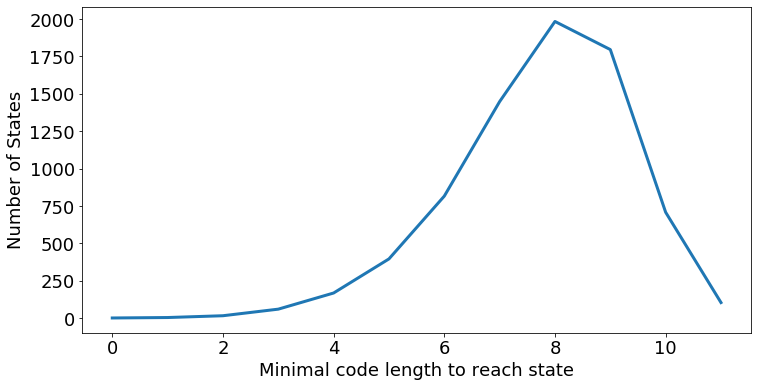

In [292]:
minimal_code_lengths = [len(code)for code in shortest_codes.values()]
counts = np.bincount(minimal_code_lengths)
plt.plot(counts, lw=3);
plt.xlabel("Minimal code length to reach state")
plt.ylabel("Number of States");

In [293]:
print("number of unique states first reached by a length k code")
{k:counts[k] for k in range(12)}

number of unique states first reached by a length k code


{0: 1,
 1: 4,
 2: 16,
 3: 60,
 4: 168,
 5: 396,
 6: 816,
 7: 1448,
 8: 1984,
 9: 1796,
 10: 708,
 11: 104}

In [294]:
np.mean(minimal_code_lengths)

7.7536328489534725

The average minimal pass sequence required to access any given state is 7.75 and the maximum code length required to access any state is 11, so if you pick a pass sequence of length 12 you are guaranteed to have picked a code which has a shorter equivalent.

But although there exist a handfull of states which actually require a sequence of moves 11 long to access there are already many times more possible pass sequences of length 7 or less than there are total possible accessible lock states. So very rapidly it becomes reasonably likely that your chosen pass code collides with a much shorter equivalent code. 

To figure out which pass sequences collide with which other ones lets generate possible pass sequences and aggretate them by which internal lock state they equate to. Below I exhaustively enumerate all possible small pass sequences and randomly sample longer sequences. 

In [295]:
import itertools

max_complete_enumeration_length = 11
max_sequence_length = 31
n_samples = 1000000

states_to_sequences = {state:[] for state in state_order}
minimal_equiv_lens = {i:[] for i in range(max_sequence_length+1)} 

for seq_len in range(max_complete_enumeration_length+1):
    print("generating all possible sequences of length", seq_len)
    seq_generator = itertools.product(*[range(4) for i in range(seq_len)])
    for seq in seq_generator:
        cstate = code_to_state(seq)
        states_to_sequences[cstate].append(seq)
        minimal_equiv_lens[seq_len].append(len(shortest_codes[cstate]))

print("randomly sampling longer sequences")
_already_sampled = set()
for i in range(n_samples):
    seq_len = np.random.randint(
        max_complete_enumeration_length+1, 
        max_sequence_length+1
    )
    
    seq = tuple(np.random.randint(4, size=seq_len))
    if seq in _already_sampled: #don't resample the same state multiple times
        continue
    cstate = code_to_state(seq)
    states_to_sequences[cstate].append(seq)
    minimal_equiv_lens[seq_len].append(len(shortest_codes[cstate]))


generating all possible sequences of length 0
generating all possible sequences of length 1
generating all possible sequences of length 2
generating all possible sequences of length 3
generating all possible sequences of length 4
generating all possible sequences of length 5
generating all possible sequences of length 6
generating all possible sequences of length 7
generating all possible sequences of length 8
generating all possible sequences of length 9
generating all possible sequences of length 10
generating all possible sequences of length 11
randomly sampling longer sequences


For all pass codes of length 0,1, and 2 the set of pass codes and the set of accessed states is one to one so every pass code access a unique state and every accessible state is accessed by only exactly one pass sequence of length 2 or less. 

For pass codes of length the mapping from pass sequence to state is very nearly unique but there are 4 states for which there are two equivalent ways to access that same state. Just for curiosity's sake here are those four pairs of equivalent length 3 pass sequences.

In [14]:
_arrow_symbols = "🠜🠝🠞🠟" 
_text_symbols = "lurd"

def to_arrows(seq):
    arrow_string = "".join([_arrow_symbols[direction_idx] for direction_idx in seq])
    return arrow_string

def to_text(seq):
    return "".join([_text_symbols[direction_idx] for direction_idx in seq])

In [15]:
for state in state_order[21:81]: #all states accessible from 3 moves
    #filter to sequences of exactly length 3 
    three_pass = [pass_seq for pass_seq in states_to_sequences[state] if len(pass_seq)==3]
    if len(three_pass) > 1: #print out all collided sequences
        print([to_arrows(pass_code) for pass_code in three_pass])

['🠜🠞🠟', '🠟🠞🠟']
['🠜🠟🠜', '🠝🠟🠜']
['🠝🠜🠝', '🠞🠜🠝']
['🠞🠝🠞', '🠟🠝🠞']


In [16]:
code_to_state((0, 2, 3)) == code_to_state((3, 2, 3))

True

But starting with pass codes of length 4 there are not only multiple same length pass codes which access the same state but there are many pass codes which are not the shortest way to access their associated lock states. A majority of pass codes of length 7 and above are not the shortest way to access their associated states. The mean length of the minimal equivalent code continues to increase for pass sequences up to length 11. After length 11 the pass codes tend to start looping back to states with much shorter minimal equivalent codes in a noticeable way. Amusingly by the metric of the average length of the minimal equivalent code length 16 pass codes are just barely more secure on average than pass codes of length 8. 

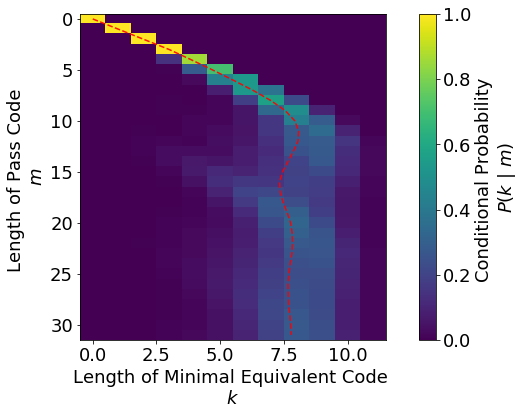

In [17]:
prob_stack = []
for m in range(max_sequence_length+1):
    bc = np.bincount(minimal_equiv_lens[m], minlength=12)
    prob = bc/np.sum(bc)
    prob_stack.append(prob)

plt.imshow(np.stack(prob_stack, axis=0), aspect=0.4)
plt.colorbar().set_label("Conditional Probability \n$P(k~|~m)$")

mean_minimal_equivalent_length = [np.sum(probs*np.arange(12)) for probs in prob_stack]

plt.plot(
    mean_minimal_equivalent_length,
    np.arange(max_sequence_length+1),
    color="r", linestyle="--", alpha=0.9
)

plt.xlabel("Length of Minimal Equivalent Code \n$k$")
plt.ylabel("Length of Pass Code \n$m$");

# Estimating Passcode Entropy

Many people will never bother to reset the lock away from its factory preset and the preset combinations are of just length 4. There are 256 possible length 4 combinations and just 248 states reachable by codes of length 4 or less. Which would take around 15 minutes to try at a speed of 1 directional input per second which isn't too much of a burden to carry out in practice. But there are 7,500 different states possible with an average minimal access length of 7.75 which works out to over 16 hours worth of attempts at the same rate of 1 directional input per second. 

Locks out there in the real world are likely to land somehwere in between those two scenarios. There simply aren't enough length 4 pass codes to offer meaningful security and as you move into the realm of longer and longer sequences the accessed states start to pile up on each other in ways that no ordinary lock consumer is likely to understand. Users pick pass sequences not lock states so those states which correspond to a larger set of pass sequences will be more likely to be picked. 

I'm sure the distribution pass sequences chosen by actual humans doesn't look like a uniform random distribution over all possible pass sequences, especially not out to lengths of 10 and beyond. But in some sense a uniform distribution over the set of possible pass sequences represents a distribution that a user of "perfect rationality" with no knowledge of the lock internals might choose. More over it is an interesting way of analyzing the level of security offered by the lock independent of the effects of human psychology.

One way to measure how secure this strategy of picking pass codes is to measure its entropy. The entropy is a measure of how large the search space is that we would need to explore before becoming confident that we would discover a working combination. Because there are only 7,501 possible lock states the maximum entropy any distribution over pass codes can possibly achieve is $log_2(7,501)$ which is 12.87 bits. But if certain lock states are much more likely to result from random pass code sequences than others then the entropy will not achieve this maximum. 

So what is the entropy of the uniform random pass sequence selection strategy and how does it compare to the theoretical maximum possible?

In [18]:
total_seqs = 0
code_count = {}
for state in state_order:
    n_seqs = len(states_to_sequences[state])
    total_seqs += n_seqs
    code_count[state] = n_seqs

state_probs = {state:code_count[state]/total_seqs for state in state_order}

In [19]:
def calc_entropy(probs, normalize=True):
    probs = np.asarray(probs).astype(float)
    if normalize:
        probs /= np.sum(probs)
    assert np.min(probs) >= 0
    #zero probability states contribute 0 to the entropy
    probs = probs[probs > 0]
    return -np.sum(probs*np.log2(probs))

In [20]:
calc_entropy(np.repeat(1/7501, 7501)) #max entropy

12.872867226786568

In [21]:
calc_entropy(list(state_probs.values()))

12.479314481335857

Impressive! The states of the lock are well mixed by a random walk in pass code space and the probability distribution over lock states for sufficiently long chosen pass sequences looks to correspond to a close to uniform distribution over lock states. So picking a truly random sequence of length 20+ works just about as well as the theoretical best possible pass code picking strategy even with knoweldge of the lock internals.

# Entropy of Short Codes

But we all know that there is no way that the typical user selected pass code is 20+ moves long. In fact I personally would be shocked to learn that the averge pass code length out in the wild is much longer than 5 or 6 and pessimistically I would bet the average pass code length is very close to the factory preset code length of 4. No doubt there will also be a number of users that opt for just length 2 or 3 sequences since they are fast to input and easy to remember and just accept the fact that makes their lock very brute force crackable. 

In order to account for the likely preponderance of shorter codes over longer ones lets suppose that all pass codes are at least length 2 but beyond that there is a 30% chance for each move that we add that we stop the pass sequence there. This puts no probability mass on the pass sequences of length 1 and yields an average pass code sequence length of 5.3 and roughly matches my intuition for the sort distribution of lengths that users might actually choose in practice. For this particular set of assumptions the pass code entropy clocks in at around 10 bits and at the same going rate of 1 directional input per second and neglecting reset time this corresponds to roughly an hour and a half to crack if we are doing an efficient search through pass code space.

In [22]:
import random

state_counts = {}
reset_prob = 0.3
steps_since_reset = 0
minimum_code_length = 2
pass_lengths = []

cstate = (0, 0, 0, 0)
for i in range(1000000):
    if (steps_since_reset > minimum_code_length) and (np.random.random() < reset_prob):
        state_counts[cstate] = state_counts.get(cstate, 0) + 1
        pass_lengths.append(steps_since_reset)
        steps_since_reset = 0
        cstate = (0, 0, 0, 0)
    else:
        cstate = random.choice(list(g.successors(cstate)))
        steps_since_reset += 1


In [23]:
np.mean(pass_lengths)

5.337296255925372

In [24]:
calc_entropy(list(state_counts.values()))

10.136754452999522

# Pass Code Cracking

I recently wanted to crack the code for one these locks I bought a few years ago but had forgotten the pass sequence for. I  knew that the sequence wasn't super long so a little brute force search and a few minutes ended up being enough to crack it. But I couldn't stop thinking about what the most efficient possible way to crack one of these locks might be in general and after a few dozen hours of research, thinking, coding, and writing here we are.

Although it might seem like these locks are much less secure than other sorts of combination locks with tens of thousands of possible pass codes in fact this is by far the most secure combination lock I can routinely find for sale. The standard combination pad locks make just barely noticeable movements and noises when you hit the right number and if you have sensitive hearing and nimble fingers you can pretty easily crack one of these locks within a few minutes of trying. I've tried it on a couple of locks and was able to pull it off after a few tens of minutes of practice. But despite there being "just" 7,500 usable combinations for this padlock there are no discernable tells for when you might be getting close to the right lock state. 

Which means that if you go the trouble of setting a new pass sequence that is at least 7 or more moves long a cracker will have no choice but to do a brute force search over a broad range of all possible lock states. 
Without some knowledge of the structure of the internal lock states this would be a very hard job indeed since you would need to enumerate all possible pass code sequences. But since we can enumerate the 7,500 states and minimal pass code sequences for each state and know that the average such pass code length comes in at 7.75, Completely testing for all possible lock states takes just 7500*(7.75+1)=65,625 inputs counting the lock reset in between attempts as one move. Which is 18 hours of straight attempts at one input per second. Which doesn't seem at all worth it when compared to the alternative of some bolt cutters and/or buying a new lock.

Buuuut, enumerating the set of minimal sequences for each state and trying them out one at a time by resetting in between and putting each sequence in one at a time is a lot of wasted inputs! The lock will open any time it finds itself in its memorized secret state and it doesn't matter how long the sequence of moves to get there has been be it 4 or 400. 

Which means that if you could utilize the transition structure between states to plan an efficient tour of all states then in principle you could test a new lock state for each and every directional input instead of once every 8.75 inputs on average (counting resets) quite a time savings! If a completely minimal tour is possible that could mean that at the same rate of 1 input per second you might be able to cover the complete state space in "only" 2 hours. 

Which is very similar to a situation considered in an other <a href=http://asymptoticlabs.com/blog/posts/loopy-locks-and-graphs.html>blog post</a> of mine dealing with the state graph of a lock (A sentence I am somewhat mystified to find myself saying since my primary hobby is ML not locks and graphs).

### A Note about length 4

Since the preset codes are all exactly length 4 sequences this case deserves a little special attention. 
As we will see shortly, the state graph corresponding to states of access length 4 and less is a directed acyclic graph. So no matter how clever you are you cannot come up with an efficient tour of these states which visits the earlier states a small number of times, at least not if you want to stay just within this search space. So if you are certain that your lock is still set to a factory preset then you are probably best off just checking all possible unique states accessible by length 4 codes. There turn out to be 248 length 4 accessible states which isn't much less than the full set of 256 possible codes so cracking efforts for sequences of exactly length 4 are probably best done via a simple brute force approach of full enumeration to keep things simple. Writing out all 256 possible length 4 sequences is somewhat of a chore so as a kindness I've done it here for you. You are welcome.
If you can manage one directional input per second or so (including reset as an input) the full set will take around 20 minutes to check them all.

In [25]:
length_4_seqs = []
i = 0
for tup in itertools.product(*[range(4) for i in range(4)]):
    length_4_seqs.append(to_arrows(tup))
    if i % 4 != 3:
        length_4_seqs.append("\t")
    else:
        length_4_seqs.append("\n")
    i+=1

print("".join(length_4_seqs))

🠜🠜🠜🠜	🠜🠜🠜🠝	🠜🠜🠜🠞	🠜🠜🠜🠟
🠜🠜🠝🠜	🠜🠜🠝🠝	🠜🠜🠝🠞	🠜🠜🠝🠟
🠜🠜🠞🠜	🠜🠜🠞🠝	🠜🠜🠞🠞	🠜🠜🠞🠟
🠜🠜🠟🠜	🠜🠜🠟🠝	🠜🠜🠟🠞	🠜🠜🠟🠟
🠜🠝🠜🠜	🠜🠝🠜🠝	🠜🠝🠜🠞	🠜🠝🠜🠟
🠜🠝🠝🠜	🠜🠝🠝🠝	🠜🠝🠝🠞	🠜🠝🠝🠟
🠜🠝🠞🠜	🠜🠝🠞🠝	🠜🠝🠞🠞	🠜🠝🠞🠟
🠜🠝🠟🠜	🠜🠝🠟🠝	🠜🠝🠟🠞	🠜🠝🠟🠟
🠜🠞🠜🠜	🠜🠞🠜🠝	🠜🠞🠜🠞	🠜🠞🠜🠟
🠜🠞🠝🠜	🠜🠞🠝🠝	🠜🠞🠝🠞	🠜🠞🠝🠟
🠜🠞🠞🠜	🠜🠞🠞🠝	🠜🠞🠞🠞	🠜🠞🠞🠟
🠜🠞🠟🠜	🠜🠞🠟🠝	🠜🠞🠟🠞	🠜🠞🠟🠟
🠜🠟🠜🠜	🠜🠟🠜🠝	🠜🠟🠜🠞	🠜🠟🠜🠟
🠜🠟🠝🠜	🠜🠟🠝🠝	🠜🠟🠝🠞	🠜🠟🠝🠟
🠜🠟🠞🠜	🠜🠟🠞🠝	🠜🠟🠞🠞	🠜🠟🠞🠟
🠜🠟🠟🠜	🠜🠟🠟🠝	🠜🠟🠟🠞	🠜🠟🠟🠟
🠝🠜🠜🠜	🠝🠜🠜🠝	🠝🠜🠜🠞	🠝🠜🠜🠟
🠝🠜🠝🠜	🠝🠜🠝🠝	🠝🠜🠝🠞	🠝🠜🠝🠟
🠝🠜🠞🠜	🠝🠜🠞🠝	🠝🠜🠞🠞	🠝🠜🠞🠟
🠝🠜🠟🠜	🠝🠜🠟🠝	🠝🠜🠟🠞	🠝🠜🠟🠟
🠝🠝🠜🠜	🠝🠝🠜🠝	🠝🠝🠜🠞	🠝🠝🠜🠟
🠝🠝🠝🠜	🠝🠝🠝🠝	🠝🠝🠝🠞	🠝🠝🠝🠟
🠝🠝🠞🠜	🠝🠝🠞🠝	🠝🠝🠞🠞	🠝🠝🠞🠟
🠝🠝🠟🠜	🠝🠝🠟🠝	🠝🠝🠟🠞	🠝🠝🠟🠟
🠝🠞🠜🠜	🠝🠞🠜🠝	🠝🠞🠜🠞	🠝🠞🠜🠟
🠝🠞🠝🠜	🠝🠞🠝🠝	🠝🠞🠝🠞	🠝🠞🠝🠟
🠝🠞🠞🠜	🠝🠞🠞🠝	🠝🠞🠞🠞	🠝🠞🠞🠟
🠝🠞🠟🠜	🠝🠞🠟🠝	🠝🠞🠟🠞	🠝🠞🠟🠟
🠝🠟🠜🠜	🠝🠟🠜🠝	🠝🠟🠜🠞	🠝🠟🠜🠟
🠝🠟🠝🠜	🠝🠟🠝🠝	🠝🠟🠝🠞	🠝🠟🠝🠟
🠝🠟🠞🠜	🠝🠟🠞🠝	🠝🠟🠞🠞	🠝🠟🠞🠟
🠝🠟🠟🠜	🠝🠟🠟🠝	🠝🠟🠟🠞	🠝🠟🠟🠟
🠞🠜🠜🠜	🠞🠜🠜🠝	🠞🠜🠜🠞	🠞🠜🠜🠟
🠞🠜🠝🠜	🠞🠜🠝🠝	🠞🠜🠝🠞	🠞🠜🠝🠟
🠞🠜🠞🠜	🠞🠜🠞🠝	🠞🠜🠞🠞	🠞🠜🠞🠟
🠞🠜🠟🠜	🠞🠜🠟🠝	🠞🠜🠟🠞	🠞🠜🠟🠟
🠞🠝🠜🠜	🠞🠝🠜🠝	🠞🠝🠜🠞	🠞🠝🠜🠟
🠞🠝🠝🠜	🠞🠝🠝🠝	🠞🠝🠝🠞	🠞🠝🠝🠟
🠞🠝🠞🠜	🠞🠝🠞🠝	🠞🠝🠞🠞	🠞🠝🠞🠟
🠞🠝🠟🠜	🠞🠝🠟🠝	🠞🠝🠟🠞	🠞🠝🠟🠟
🠞🠞🠜🠜	🠞🠞🠜🠝	🠞🠞🠜🠞	🠞🠞🠜🠟
🠞🠞🠝🠜	🠞🠞🠝🠝	🠞🠞🠝🠞	🠞🠞🠝🠟
🠞🠞🠞🠜	🠞🠞🠞🠝	🠞🠞🠞🠞	🠞🠞🠞🠟
🠞🠞🠟🠜	🠞🠞🠟🠝	🠞🠞🠟🠞	🠞🠞🠟🠟
🠞🠟🠜🠜	🠞🠟🠜🠝	🠞🠟🠜🠞	🠞🠟🠜🠟
🠞🠟🠝🠜	🠞🠟🠝🠝	🠞🠟🠝🠞	🠞🠟🠝🠟
🠞🠟🠞🠜	🠞🠟🠞🠝	🠞🠟🠞🠞	🠞🠟🠞🠟
🠞🠟🠟🠜	🠞🠟🠟🠝	🠞🠟🠟🠞	🠞🠟🠟🠟
🠟🠜🠜🠜	🠟🠜🠜🠝	🠟🠜🠜🠞	🠟🠜🠜🠟
🠟🠜🠝🠜	🠟🠜🠝🠝	🠟🠜🠝🠞	🠟🠜🠝🠟


# Graph Visualization

Before attempting to find a minimal tour of the lock state graph we are going to take a detour into visualizing its structure.

Visualizing the full 7,501 node graph in a way that makes its structure accessible is challenging to say the least. Before diving in to the full graph lets start by visualizing the states accessible by the shortest codes.

Below is the set of length 4 accessible states.

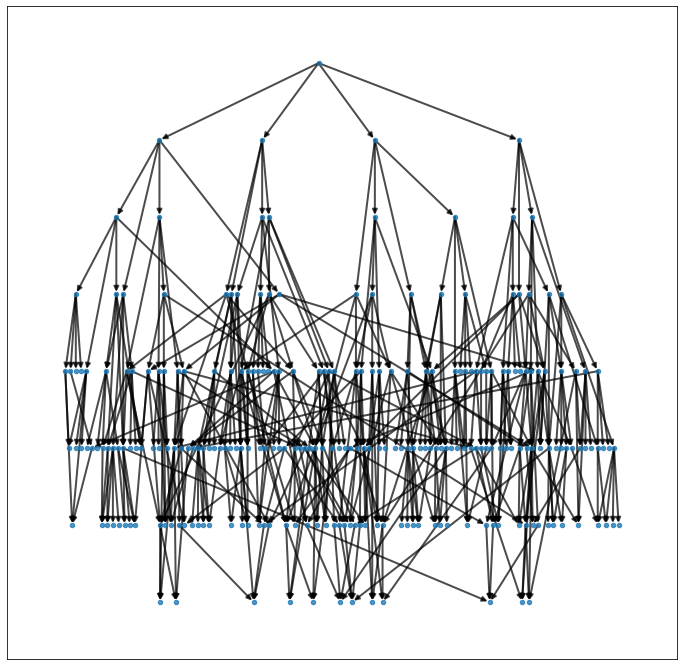

In [26]:
sg = g.subgraph(state_order[:249]) #the states are in order of minimal pass code length

layout = nx.nx_pydot.pydot_layout(sg, prog="dot", root=(0, 0, 0, 0))

fig, ax = plt.subplots(figsize=(12, 12))
node_size=20
nx.draw_networkx_edges(
    sg,
    width=2.0, 
    alpha=0.7, 
    arrows=True,
    node_size=node_size,
    pos=layout,
)
nx.draw_networkx_nodes(
    sg, 
    node_size=node_size, 
    pos=layout, 
    alpha=0.8
);

In [27]:
nx.is_directed_acyclic_graph(sg)

True

If we go one step farther and look at length 5 accessible states you can see that the graph starts looping back on itself. Based on our knowledge of the lock internals this is to be expected since roughly speaking each move rotates 3 of the combination disks roughly 1/5 of a turn.

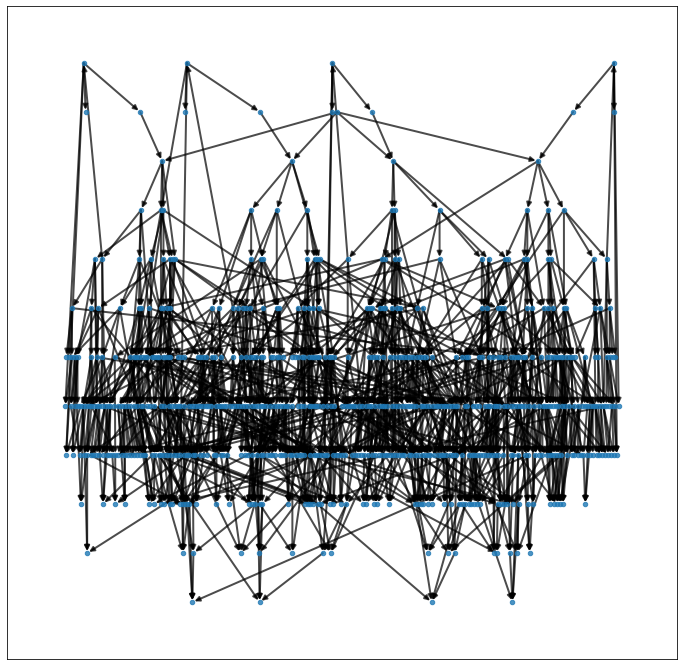

In [28]:
sg = g.subgraph(state_order[:645]) #the states are in order of minimal pass code length

layout = nx.nx_pydot.pydot_layout(sg, prog="dot", root=(0, 0, 0, 0))

fig, ax = plt.subplots(figsize=(12, 12))
node_size=20
nx.draw_networkx_edges(
    sg,
    width=2.0, 
    alpha=0.7, 
    arrows=True,
    node_size=node_size,
    pos=layout,
)
nx.draw_networkx_nodes(
    sg, 
    node_size=node_size, 
    pos=layout, 
    alpha=0.8
);

In [29]:
nx.is_directed_acyclic_graph(sg)

False

The set of all length 6 accessible states is already reaching into the thousands and starts to get rather unruly. The graph is no longer really essentially a directed acyclic graph (DAG) and so the pydot layout that worked so well for up to state 6 becomes basically useless (and takes quite a long time to compute). 

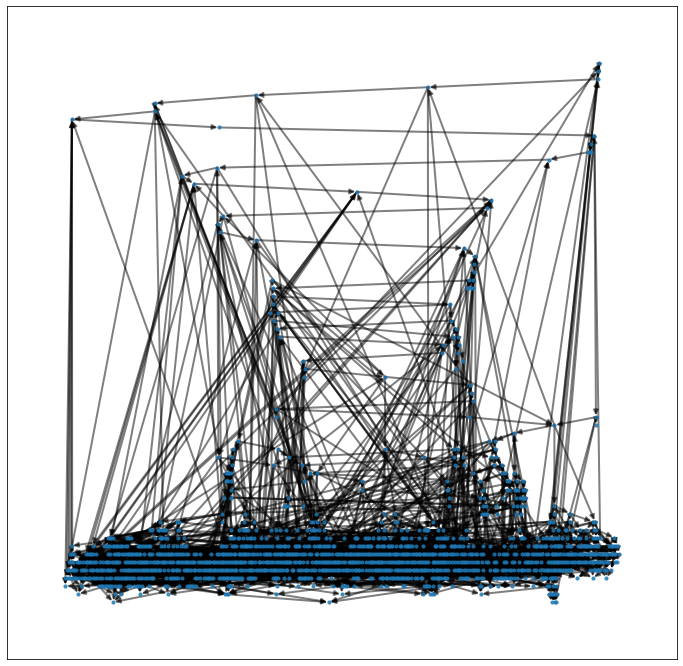

In [30]:
sg = g.subgraph(state_order[:1461]) #the states are in order of minimal pass code length

layout = nx.nx_pydot.pydot_layout(sg, prog="dot", root=(0, 0, 0, 0))#nx.layout.spectral_layout(sg)

fig, ax = plt.subplots(figsize=(12, 12))
node_size=10
nx.draw_networkx_edges(
    sg,
    width=2.0, 
    alpha=0.5, 
    arrows=True,
    node_size=node_size,
    pos=layout,
)
nx.draw_networkx_nodes(
    sg, 
    node_size=node_size, 
    pos=layout, 
    alpha=0.8
);

If we visualize the nearly same subgraph with a spectral layout (one of my favorite graph layout strategies despite its short comings) we get something quite striking. It helps in this case to exclude the reset state node since it is a little bit of an oddball and kind of messes up the symmetry of the graph that you otherwise can see. (The reset node is the first state in the state_order list since it is ordered from shortest access length to longest.) 

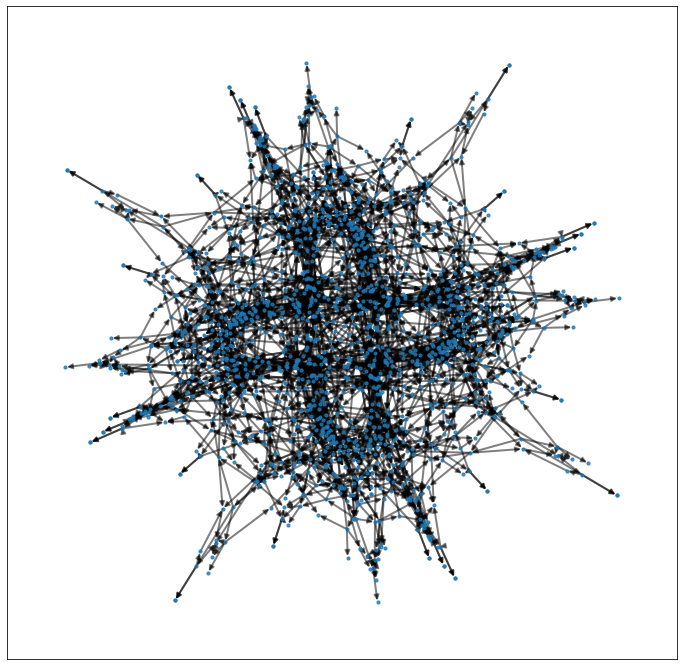

In [31]:
sg = g.subgraph(state_order[1:1461]) #the states are in order of minimal pass code length

layout = nx.layout.spectral_layout(sg)

fig, ax = plt.subplots(figsize=(12, 12))
node_size=10
nx.draw_networkx_edges(
    sg,
    width=2.0, 
    alpha=0.5, 
    arrows=True,
    node_size=node_size,
    pos=layout,
)
nx.draw_networkx_nodes(
    sg, 
    node_size=node_size, 
    pos=layout, 
    alpha=0.8
);

From this view we can see a rather striking "four leaf clover" sort of structure emerge. As a first thought I suspected that the 4 leaves of the clover correspnded to the 4 "trivial" loops in state space that you can get by simply pushing the same direction 5 times in a row. As it turns out I was sort of correct but there are 12 different kinds of "trivial" loop not just 4 a fact we will return to shortly.

I would feel remiss if I didn't show the results of at least one standard graph layout technique on the full graph. Now that we are already at a scale of thousands of nodes and edges we might as well go all the way up to the full graph and just see what happens. 

Most of the layouts in the networkx package choke when I feed them graphs of this size and while some of them will eventually return something it isn't usually worth the wait. The spectral layout is tolerably fast to compute and if you set the arrows=False flag when drawing the network edges the visualization doesn't take too long to draw even if the result isn't particularly enlightening. About the only obvious piece of information about the graph structure that you can glean from the graph layout is that the reset state node which is clearly a bit of an oddball.

One thing to notice in the below graph is that there are often many points mapped exactly on top of each other which is why the lines appear more and less dark since they are drawn with some transparency.

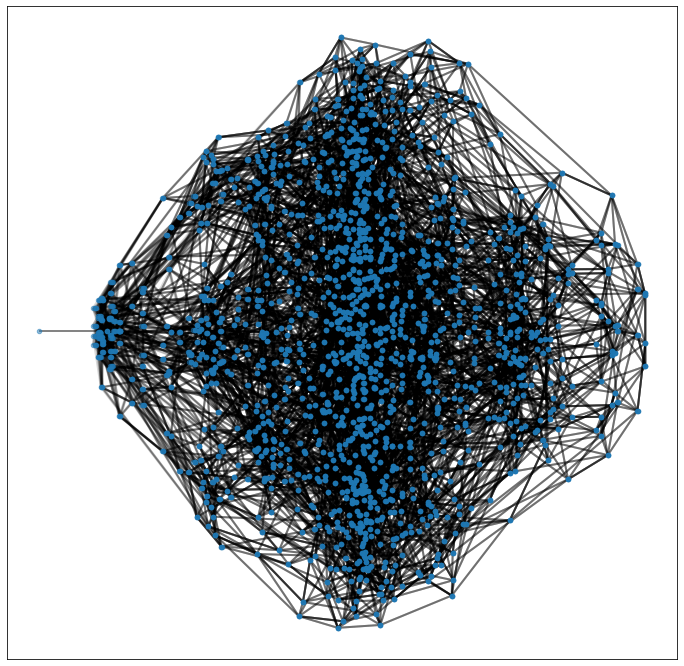

In [32]:
sg = g

layout = nx.layout.spectral_layout(sg)

fig, ax = plt.subplots(figsize=(12, 12))
node_size=20
nx.draw_networkx_edges(
    sg,
    width=2.0, 
    alpha=0.15, 
    arrows=False,
    node_size=node_size,
    pos=layout,
)
nx.draw_networkx_nodes(
    sg, 
    node_size=node_size, 
    pos=layout, 
    alpha=0.5
);

 Fun to look at but perhaps less than informative.

# A Two Component State Notation

If we want to get a really good visualization of the state graph we are going to have to dig a little deeper in terms of understanding its dynamics and think clearly about what sort of properties a "good" visualization of the state space should have.

In order to get a better visualization of the flow of the lock states therefore it is probably worthwile to try and spend a little time better understanding the lock dynamics. If you took a look at that analysis by Michael Huebler I linked above then you will have seen that he chose to represent the lock states a little differently than I have. 

The combination disks have 15 possible operating positions each separated by 24 degrees. But because of the way the lock internals work it is helpful to think of those 15 positions as being broken up into 5 major divisions 72 degrees apart with each of the major divisions broken up into 3 subdivisions which differ from the central major division rotation by -24, 0, or +24 degrees. Michael had the good sense to devise a 2 part notation for each combination disk by denoting the major position of the disk by an integer $n\in{0, 1, 2, 3, 4}$  and the minor subdivisions by a number $m\in{-1,0,1}$ . With the total rotation angle of the disk being 72*n+24*m. 

The genius of this 2 component notation is that it very helpfully decouples the dynamics of the major and minor segments of the lock which have very different behaviors. The $n$ index tends to simply roll forward one tick at a time and effectively keeps track of the number of times that the state of each disk has been affected mod 5. On the other hand the $m$ index snaps to specific values each time a direction is entered 0 for a move directly towards a disk and +1 or -1 for moves towards adjacent combination disks, -1 for clockwise adjacency and +1 for counter clockwise adjacency. 

## Chirality and 4-Phase

Naively you might expect the total number of possible states to be $15^4 = 5^4*3^4 = 50,625$ since there are 4 disks and 15 possible positions for each disk. But although all $5^4$ major division combinations are possible to achieve the $m$ indexes are heavily dependent on each other. The $m$ values of 3 of the 4 disks are deterministically set by the last move made and the remaining $m$ value will be whatever was leftover from the second to last unique directional input. This means that there are just 12 total possible combinations of the 4 different $m$ values. 

Because of these two different sorts of behavior of the $n$ and $m$ indexes I am going to call the particular configuration of 4 $n$ indexes the "4-phase" of the lock and the configuration of the 4 $m$ indexes the "chirality" of the lock. 

The $n$ indexes proceed forward one step at a time and loop back around after 5 steps and after all they describe the motions of disks and so it very naturally describes the "phase" of a rotational motion. So I think the term phase is an extremely natural fit.

It is less obvious why I would want to call the $m$ indexes the chirality of the lock. Chirality means "handedness" and is used in physics to describe directional asymmetries. Each time you enter a direction into the lock you snap the $m$ index configuration to one of 12 possible configurations. I think those 12 configurations are naturally described by the 12 length 2 codes which achieve them. Since this represents a sort of directional asymmetry of the lock states calling it a "chirality" seems very natural to me. Plus I really like the word chirality.

In [33]:
def get_phase(state):
    return tuple([(i//3) for i in state])

def get_chirality(state):
    return tuple([i % 3 for i in state])

One technicality worth mentioning is that there are actually 13 possible $m$ index configurations not 12.

In [34]:
chiralities = list(set([get_chirality(state) for state in state_order]))
len(chiralities)

13

But this is only because the reset state is special and has no sort of intrinsic directionality. Once any directional inputs have been made this special chirality (or lack thereof) is no longer possible. 

In [35]:
chiralities = list(set([get_chirality(state) for state in state_order[1:]]))
len(chiralities)

12

# Chirality Graph

With this 2 component lock state in mind we can now analyze the dynamics of each of the state components. The chirality state somewhat affects how the phase state evolves but the evolution of the chirality is completely independent of the phase so we will start by taking a look at the graph induced by considering just the chirality of the lock states before digging in to the phase evolution.



In [36]:
chiral_roots = []
root_directions = []
chirality_to_directions = {}

for i in range(4):
    for j in range(4):
        if i==j:
            continue
        chir_label = (i, j)
        root_directions.append(chir_label)
        state = code_to_state(chir_label)
        chiral_roots.append(state)
        chirality_to_directions[get_chirality(state)] = chir_label
        

In [37]:
chirality_graph = nx.DiGraph()

for state in chiral_roots:
    for direction in range(4):
        next_state = advance_lock_state(state, direction)
        chirality_graph.add_edge(get_chirality(state), get_chirality(next_state))

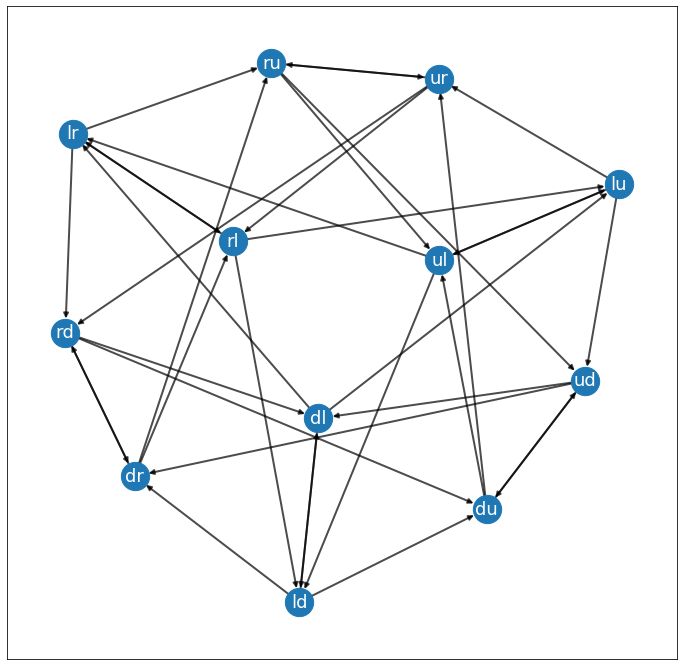

In [38]:
sg = chirality_graph

layout = nx.layout.kamada_kawai_layout(sg)

fig, ax = plt.subplots(figsize=(12, 12))
node_size=800
nx.draw_networkx_edges(
    sg,
    width=2.0, 
    alpha=0.7, 
    arrows=True,
    node_size=node_size,
    pos=layout,
)
nx.draw_networkx_nodes(
    sg, 
    node_size=node_size, 
    pos=layout, 
    alpha=1.0
);

#I would have liked to have put arrows for the annotations but the matplotlib font didn't like it.
nx.draw_networkx_labels(
    sg,
    pos=layout,
    labels={
        chir:to_text(chirality_to_directions[chir])
        for idx, chir in enumerate(chirality_graph.nodes())
    },
    font_size=18,
    font_color="#ffffff"
);

# Chirality Color Map

This chirality is an important aspect of every node and the ability to determine where in the chirality subgraph each node is would be a valuable asset in being able to interpret the structures of the graph as a whole. 

Towards that end I am turning the chirality subgraph layout into a color mapping by associating colors with particular points in the plane of the 2D layout of the above graph. After trying out a number of different coloring schemes I settled on the below blue/purple/orange scheme. I tried out some other coloring schemes which assigned more visually distinct colors to the 12 nodes but those schemes never looked good to me. I think this scheme looks good and still gives some idea of the connectivity between nodes. Nodes with more similar colors are more tightly knit together in the chirality subgraph.

In [39]:
rot = 0.35
radius = 0.5
_color_pts = np.array(
    [
        radius*np.array([np.cos(theta), np.sin(theta)]) 
        for theta in rot+np.linspace(0, 2*np.pi, 4)[:3]
    ]
)
_colors = np.array(
    [
        [0.0, 0.9, 0.5],
        [0.6, 0.1, 0.8], 
        [1.0, 0.6, 0.1], 
    ]
)

def pos_to_color(pos):
    pos = np.asarray(pos)
    sq_dists = np.sum((pos-_color_pts)**2, axis=1)
    color_weights = np.exp(-1.0*sq_dists/0.8**2)
    #color_weights -= 0.5*np.min(color_weights)
    color_weights /= np.sum(color_weights)
    
    color = np.zeros(3)
    for i in range(len(_color_pts)):
        w = color_weights[i]
        c = _colors[i]
        color += w*c
    
    return color

In [40]:
chirality_layout = nx.layout.kamada_kawai_layout(chirality_graph)
chir_to_color = {node:pos_to_color(chirality_layout[node]) for node in chirality_graph.nodes()}

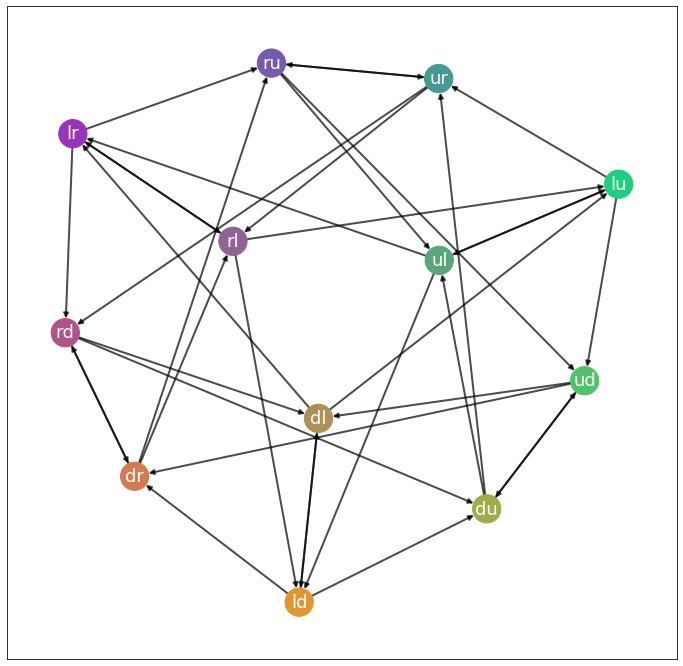

In [41]:
sg = chirality_graph

layout = nx.layout.kamada_kawai_layout(sg)

fig, ax = plt.subplots(figsize=(12, 12))
node_size=800
nx.draw_networkx_edges(
    sg,
    width=2.0, 
    alpha=0.7, 
    arrows=True,
    node_size=node_size,
    pos=layout,
)

nx.draw_networkx_nodes(
    sg, 
    node_size=node_size, 
    pos=layout, 
    node_color=[chir_to_color[node] for node in sg.nodes()],
);

#I would have liked to have put arrows for the annotations but the matplotlib font didn't like it.
nx.draw_networkx_labels(
    sg,
    pos=layout,
    labels={
        chir:to_text(chirality_to_directions[chir])
        for idx, chir in enumerate(chirality_graph.nodes())
    },
    font_size=18,
    font_color="#ffffff"
);

#helper plot for tweaking the color mapping
#plt.scatter(*_color_pts.T, c=_colors, s=100)

# The "Trivial" Cycles
 
Now we can start thinking about the "phase" component of the state dynamics. The most interesting (and difficult to deal with) aspect of the phase is that it loops back around on itself. Each move we input rotates 3 of the 4 disks roughly 1/5 of a turn. In fact if we keep inputing the same direction 5 times in a row then these 3 disks get rotated exactly 1/5 of a turn with each move and after 5 moves we end up back in exactly the same lock state as when we started.

Though there are many many possible cycles in the lock state graph these are the shortest possible cycles and I'm going to dub them the "trivial loops". There are 1,500 of these loops. Every lock state participates in exactly one such loop with the peculiar identity of each loop being determined by the relative phase offsets of the 3 disks which are incremented over the course of the loop, the constant phase of the non participating disk, and the chirality of the peculaiar state. (25 possible phase offsets * 5 phases of the unchanging disk * 12 chiralities) = 1500.

In [42]:
trivial_loops = []
loop_visited_states = set()

for start_state in state_order[1:]:
    cstate = start_state
    if cstate in loop_visited_states:
        continue #state participates in an already sampled loop
    shortest_seq = states_to_sequences[cstate][0]
    direction = shortest_seq[-1]
    state_loop = [cstate]
    for i in range(5):
        loop_visited_states.add(cstate)
        cstate = advance_lock_state(cstate, direction)
        state_loop.append(cstate)
        
    assert state_loop[0] == state_loop[-1] #check that we closed the loop in state space
    trivial_loops.append(state_loop)

In [43]:
len(trivial_loops)

1500

In [44]:
#the phases march forward in lock step
#incrementing the pase of the participating disks by 1 each time
[get_phase(s) for s in trivial_loops[0]]

[(1, 0, 0, 0),
 (2, 1, 0, 1),
 (3, 2, 0, 2),
 (4, 3, 0, 3),
 (0, 4, 0, 4),
 (1, 0, 0, 0)]

In [45]:
#the chirality remains unchanged over the course of the loop
[get_chirality(s) for s in trivial_loops[0]]

[(0, 1, 0, 2),
 (0, 1, 0, 2),
 (0, 1, 0, 2),
 (0, 1, 0, 2),
 (0, 1, 0, 2),
 (0, 1, 0, 2)]

# Loopy Graph Layouts

These loops in can act as guides to help us orient ourselves in the graph layouts. Lets take a look at where some of these loops land in the spectral graph layout from above. Since the loops have a constant chirality lets color each loop according to its chirality to add a little extra context.

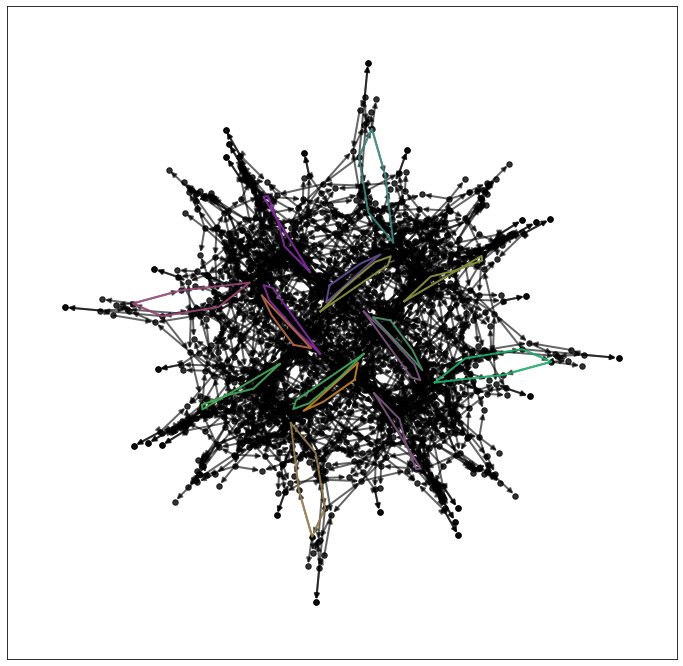

In [46]:
sg = g.subgraph(state_order[1:1461]) #the states are in order of minimal pass code length

layout = nx.layout.spectral_layout(sg)

fig, ax = plt.subplots(figsize=(12, 12))
node_size=30
nx.draw_networkx_edges(
    sg,
    width=2.0, 
    alpha=0.6, 
    arrows=True,
    node_size=node_size,
    pos=layout,
)
nx.draw_networkx_nodes(
    sg, 
    node_size=node_size, 
    pos=layout,
    node_color="k",
    alpha=0.8
);

for loop_states in trivial_loops:
    x_coords = [layout[s][0] for s in loop_states if s in layout]
    y_coords = [layout[s][1] for s in loop_states if s in layout]
    if len(x_coords) < 6: #the first and last state is repeated so if all states are present there will be 6  
        #not all nodes from this loop are included lets skip it
        continue
    loop_color = chir_to_color[get_chirality(loop_states[0])]
    plt.plot(x_coords, y_coords, color=loop_color, alpha=0.8, lw=2.0);

The trivial loops in this layout actually tend to have all 5 points lying very close to straight lines! 

This makes sense when you stop to think about the details of the spectral layout strategy. The spectral layout is a clever way of using the first few eigenvectors of the graph Laplacian to assign nodes to points in the plane. The method is based on the observation that the only non-zero eigenvector of the graph laplacian for a completely connected graph (a clique) is a constant vector and corresponds to an eigenvalue which is equal to the size of the clique. This means that if your graph happens to be able to be decomposed as a few disconnected cliques (of differing sizes) then the first few eigenvectors of the graph Laplacian will look like indicator functions for the largest cliques (0 entries for non-member nodes and constant entries for member nodes). Once you remove connections from the cliques and/or add connections between cliques there are no real guarantees about how you can interpret the eigenvector entries anymore but in practice the spectral layout often works well even when there is no clear clustering style interpretation for them anymore.

The properties of eigenvectors guarantee uniqueness of eigenvectors when the eigenvalues of those vectors differ significantly. But when the eigenspectrum of the matrix has multiple identical entries any linear mixture of eigenvectors with the same eigenvalue is also an eigenvector. Applying that knowledge to the spectral layout technique in this case it seems that what is happening is that the eigenspectrum of the graph laplacian is very flat because the graph essentially consists of many copies of a few tight knit cycles each of which have the same structure and would have the same eigenvalue. Because the eigenvalues are so close to each other the linear subspaces of eigenvectors mix and instead of getting the clean indicator function vectors that we would get from disconnected cliques we get arbitrary linear mixtures and the trivial loops get smeared out into lines in eigenvector space.

Anyway that's my story and I'm sticking to it.

I went looking for some support for that theory by looking to see if the spectrum of the graph Laplacian for the lock graph is somehow "especially flat". I have to say it doesn't really seem like it. I compared it to the eigenspectrum of a randomly connected sparse graph of similar density. Both have very flat spectra and although the random graph has a much sharper upturn for the largest few eigen values I'm not really sure if this represents a significant difference (or for that matter really supports my theory). 

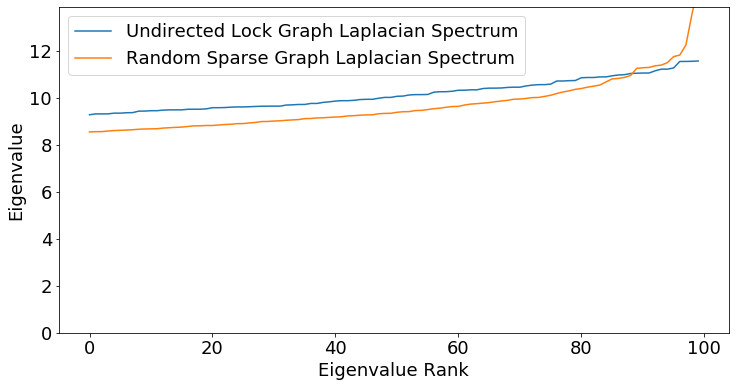

In [47]:
sgmat = nx.to_scipy_sparse_matrix(sg.to_undirected(), dtype=float)
sglap = scipy.sparse.csgraph.laplacian(sgmat)
k=100
evals, evecs = scipy.sparse.linalg.eigsh(sglap, k=k)

rmat = scipy.sparse.random(*sgmat.shape, density=len(sgmat.data)/np.prod(sgmat.shape))
rmat += rmat.transpose()

lap_r = scipy.sparse.csgraph.laplacian(rmat)
evals_r, evecs_r = scipy.sparse.linalg.eigsh(lap_r, k=k)

plt.plot(evals, label="Undirected Lock Graph Laplacian Spectrum")
plt.plot(evals_r, label="Random Sparse Graph Laplacian Spectrum")

plt.ylim(0, 1.2*np.max(evals), )
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue Rank")
plt.legend(loc="best")

# Mapping Cycles to Circles

Interesting though the trivial cycles are getting mapped to tight lines is, it isn't really what we would like to have happen in an "ideal" layout of the states. It would be much nicer if we could think of a way to organize the nodes in the state graph such that the 1,500 trivial loops are all mapped onto circles in the plane.

Any one phase $k$ can be mapped onto a circle by picking the points $(c_x + cos(2\pi~k/5),~ c_y+sin(2\pi~k/5))$. Picking only one of the 4 phase components to listen to however would map 1 out of 4 trivial loops to a single point and builds an artificial directional asymmetry into our layout since it treats one of the combination disks as special. But there is in fact one special combination disk in each state, which is the combination disk corresponding to the last move made. Mapping the phase of that combination disk to the points on a circle does indeed give us a layout which maps all trivial loops to circles in the plane since the last move made is the same for all of the states in these loops.

We can then use the rest of the properties of the lock state like the chirality, the relative phase offsets of the adjacent disks, and the phase of the disk opposite to the disk last moved towards to set the position of the circle centers. Below is an attempt at a "logical" layout function which blends together different layouts for each aspect of the lock states to get one complete layout. 
 

In [104]:
def get_factorized_phase(state):
    if state == (0, 0, 0, 0):
        return (0, 0), (0, 0)
    
    chir = get_chirality(state)
    last_direction = chirality_to_directions[chir][-1]
    
    phase_vec = get_phase(state)
    last_direction_phase = phase_vec[last_direction]
    opposing_direction_phase = phase_vec[(last_direction+2)%4]
    
    prev_offset = (last_direction_phase-phase_vec[(last_direction-1)%4])%5
    next_offset = (last_direction_phase-phase_vec[(last_direction+1)%4])%5
    
    return (prev_offset, next_offset), (opposing_direction_phase, last_direction_phase)

def layout_fn(
    state,
    scales
):
    if state == (0, 0, 0, 0):
        return np.array((0, 0)) #map the reset state to the origin
    
    phase_offsets, opposing_phases = get_factorized_phase(state)
    prev_offset, next_offset = phase_offsets
    
    t1 = 2*np.pi/5*opposing_phases[0]
    t2 = 2*np.pi/5*opposing_phases[1]
    
    p1 = np.array([np.cos(t1), np.sin(t1)])
    p2 = np.array([np.cos(t2), np.sin(t2)])
    p3 = np.array([prev_offset-2, next_offset-2])
    chir = get_chirality(state)
    p4 = chirality_layout[chir]
    
    pt = np.zeros(2, dtype=float)
    for delta, scale in zip([p1, p2, p3, p4], scales):
        pt += scale*delta
    
    return pt

Lets redraw the same subgraph from above with some arbitrarily chosen scale factors for how each aspect of the lock state affects its positioning.

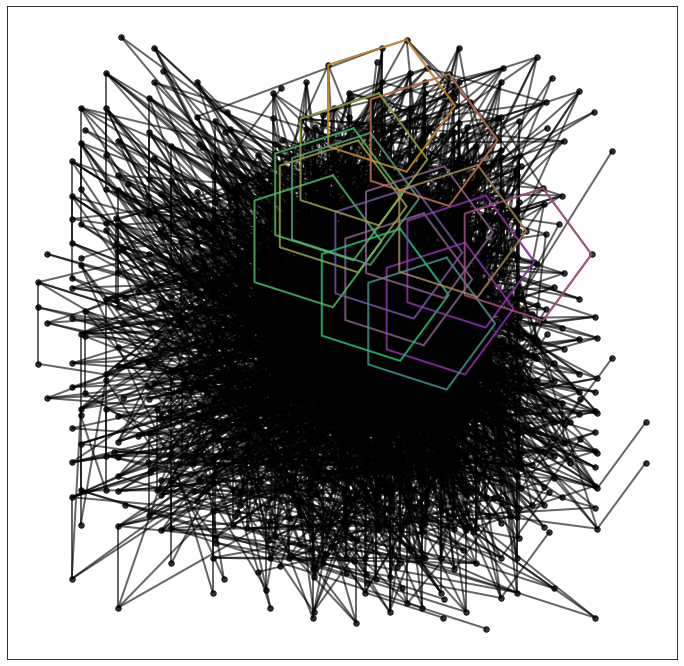

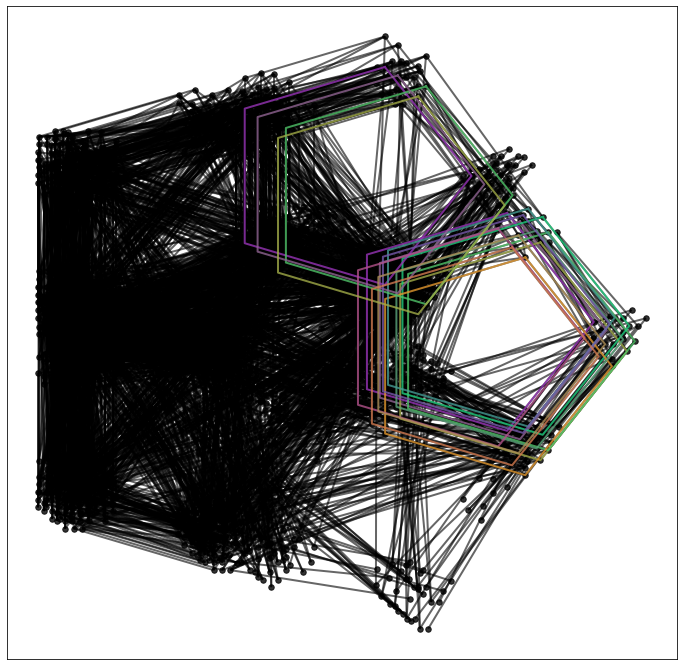

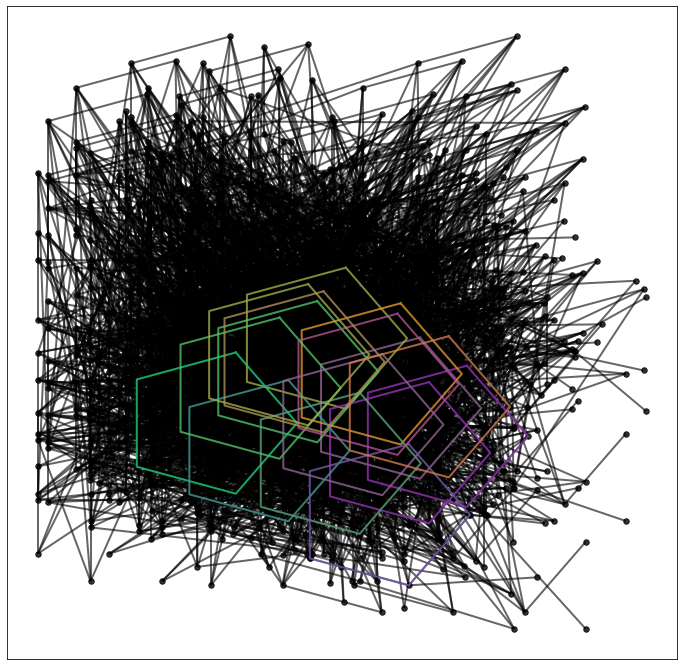

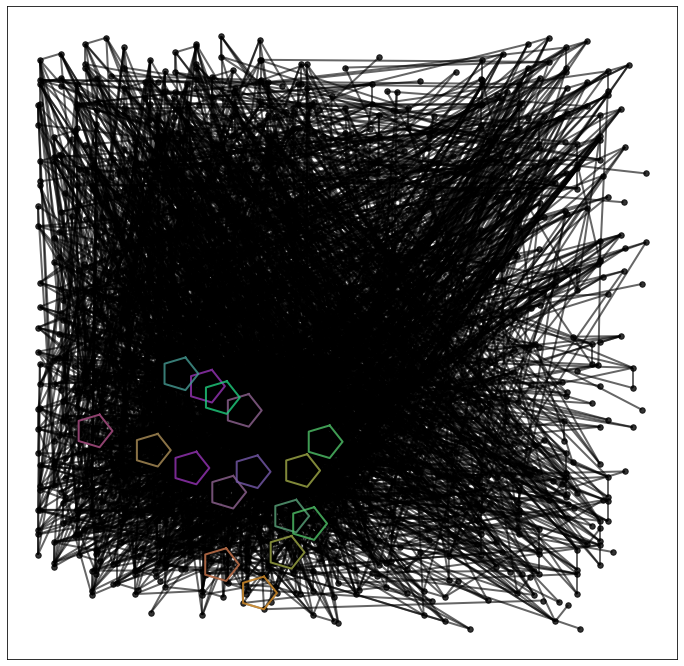

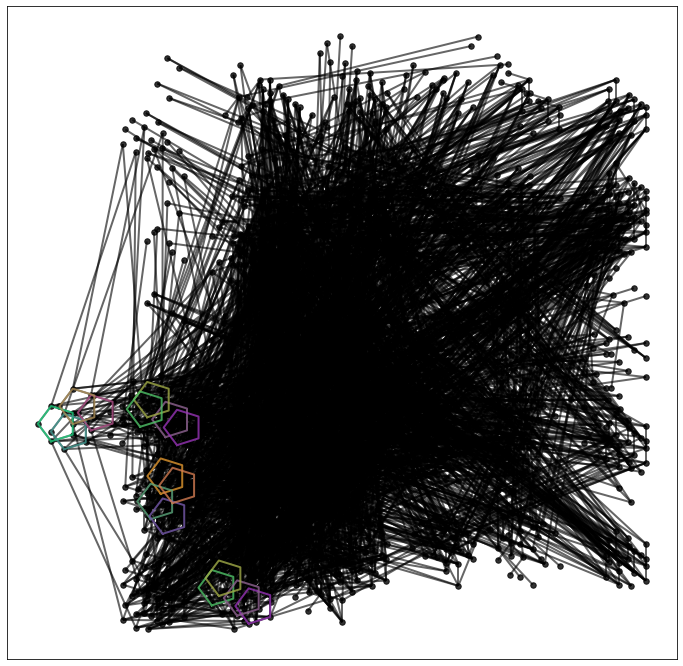

In [143]:
sg = g.subgraph(state_order[:1461])

np.random.seed(12345)

for i in range(5):
    rscales = np.random.normal(size=4)

    layout = {}
    for state in sg.nodes():
        pos = layout_fn(
            state, 
            rscales,
        )
        layout[state] = pos 


    fig, ax = plt.subplots(figsize=(12, 12))
    node_size=30
    nx.draw_networkx_edges(
        sg,
        width=2.0, 
        alpha=0.6, 
        arrows=False,
        node_size=node_size,
        pos=layout,
    )
    nx.draw_networkx_nodes(
        sg, 
        node_size=node_size, 
        pos=layout,
        node_color="k",
        alpha=0.8
    );

    for loop_states in trivial_loops:
        x_coords = [layout[s][0] for s in loop_states if s in layout]
        y_coords = [layout[s][1] for s in loop_states if s in layout]
        if len(x_coords) < 6:
            #not all nodes from this loop are included lets skip it
            continue
        loop_color = chir_to_color[get_chirality(loop_states[0])]
        plt.plot(x_coords, y_coords, color=loop_color, alpha=0.8, lw=2.0);
        
    plt.show()

As we can see from the colored loop overlays each trivial loop is indeed getting mapped onto a circle in the graph layout plane and although these layouts do look rather interesting even with just the first 1,460 of the nodes out of the full state graph there are just too many states to be able to make out much of any structure in the graph. The edges and nodes are just too numerous.

But now we can really put the chirality color scheme to work. Instead of making all the edges and nodes black lets go ahead and color them according to chirality of the leading edge state. I admit that the below images may not help you nderstand the graph all that much better than the black blobs. But in the end I have to admit that I am very unlikely to ever figure out a way to visualize the graph that is just strictly better than other ways and  I want to move on to other things. 

Below is a set of "logical" graph layouts which emphasize different aspects of the state dynamics.

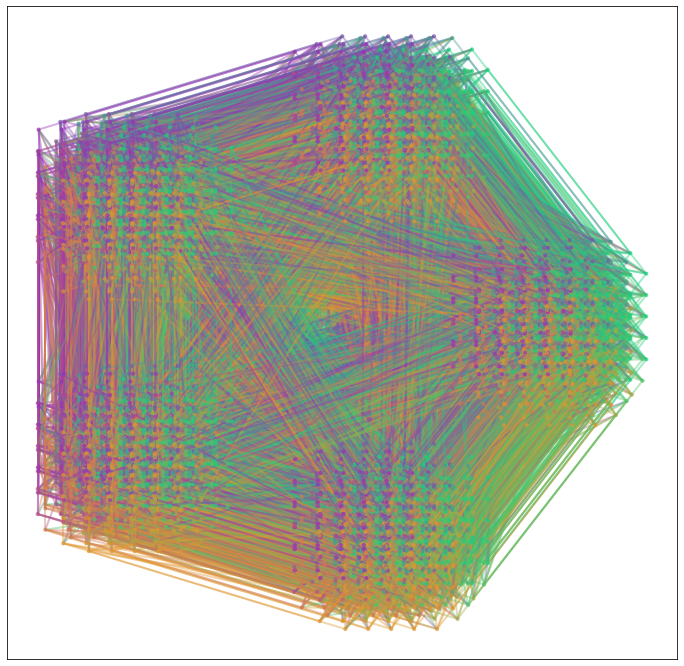

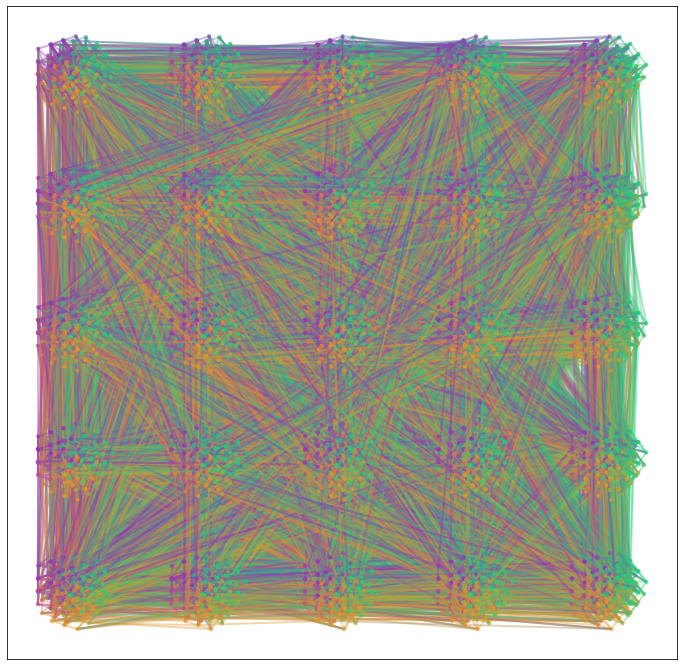

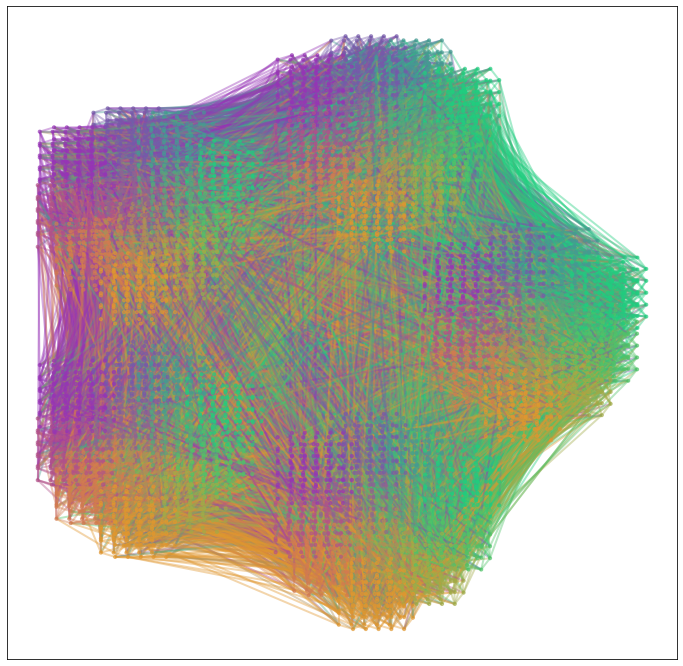

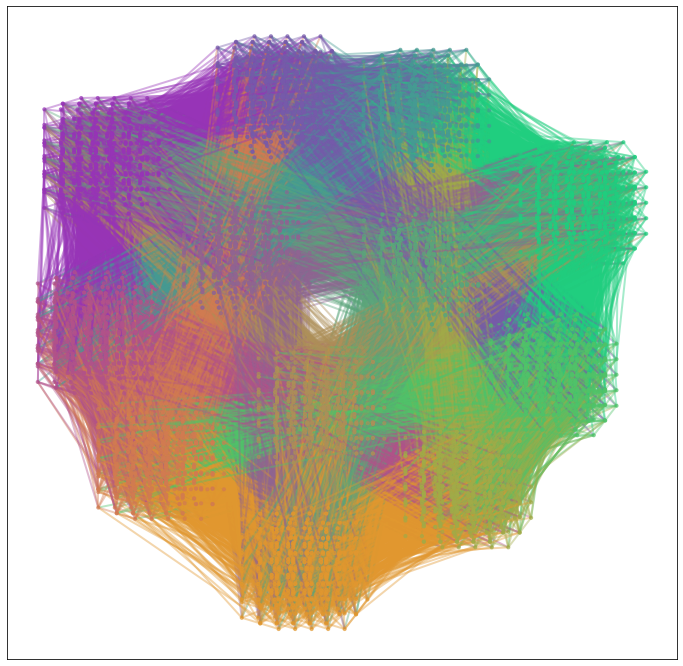

In [167]:
sg = g.subgraph(state_order[1:])

scale_sets = [
    [0.5, 5, 0.5, 0.75],
    [0.3, 0.3, 3.5, 0.5],
    [5.0, 0.3, 0.3, 2.0],
    [0.3, 0.3, 0.3, 5.0]
]

for rscales in scale_sets:
    layout = {}
    for state in sg.nodes():
        pos = layout_fn(
            state, 
            rscales, 
        )
        layout[state] = pos 


    fig, ax = plt.subplots(figsize=(12, 12))
    node_size=10
    
    edge_colors = [
        chir_to_color[get_chirality(e[0])] for e in sg.edges()
    ]
    
    nx.draw_networkx_edges(
        sg,
        width=2.0, 
        alpha=0.4, 
        arrows=False,
        edge_color=edge_colors,
        node_size=node_size,
        pos=layout,
    )
    nx.draw_networkx_nodes(
        sg, 
        node_size=node_size, 
        pos=layout,
        node_color=[chir_to_color[get_chirality(s)] for s in sg.nodes()],
        alpha=0.6,
    );
    
    plt.show()

# Time to crack

If you wanted to test all possible lock states to see if they correspond to the pass code state how fast could you possibly do it? Lets calculate a curve which represents the cumulative probability of having cracked the lock as a function of the number of lock inputs (counting a reset as 1 input).

The "obvious" thing to do is to try all the possible codes in order from the shortest to longest codes. We can perhaps do slightly better by considering how all possible pass codes pile up on each other in lock state space and ordering the lock states from most to least probable. Trying out each lock state in this way requires 1 reset and a number of directional inputs equal to the minimum length pass code required to access that state. We can recycle our lock state probability estimates from earlier to get us this state enumeration order. 



In [242]:
visit_total = np.sum([state_counts.get(state, 0)+2 for state in state_order])
code_probs = {state:(state_counts.get(state, 0)+2)/visit_total for state in state_order}

In [243]:
access_lengths_ordered = [1+mcl for mcl in minimal_code_lengths]
associated_probs_ordered = [code_probs[state] for state in state_order]


In [244]:
descending_entropy_states = sorted(state_order, key=lambda state: code_probs[state], reverse=True)

In [245]:
access_lengths_mp_first = [1+len(states_to_sequences[state][0]) for state in descending_entropy_states]
probs_mp_first = [code_probs[state] for state in descending_entropy_states]

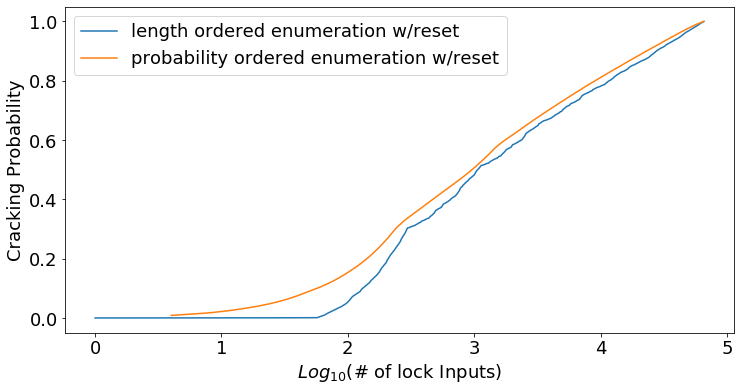

In [246]:
plt.plot(
    np.log10(np.cumsum(access_lengths_ordered)), 
    np.cumsum(associated_probs_ordered), 
    label="length ordered enumeration w/reset"
)
plt.plot(
    np.log10(np.cumsum(access_lengths_mp_first)), 
    np.cumsum(probs_mp_first),
    label="probability ordered enumeration w/reset"
)

plt.xlabel("$Log_{10}$(# of lock Inputs)")
plt.ylabel("Cracking Probability")
plt.legend()

In [211]:
len(minimal_code_lengths)

7501

Even giving higher probabilities to shorter code sequences You need a thousand or more lock inputs before having a 50/50 chance of hitting the pass code state and need more than 10,000 inputs before. 

# A cracking good tour

But if the goal is to minimize the number of lock inputs required to hit the lock states we can do a hell of a lot better than just ordering the states by likelihood and inputting the shortest sequence. We can exploit our complete knowledge of the state graph to find a short tour of all the lock states which uses a minimal number of inputs. In principle it may be possible to do a completely minimal tour of the internal lock states where we visit each lock state only exactly once. I didn't manage to find such a tour but even so I found a tour which completely covers the lock states with no resets and which requires only 14,000 lock inputs as compared to the 65,000+ inputs required for a minimal cover of the lock states if you always reset between lock states. 

In [248]:
def greedy_tour_search(
    G, 
    node_scores,
    start_node=None,
    max_tour_length=100000,
    randomize_ties=True,
    fill_score=0,
):
    nodes = list(G.nodes())
    n_nodes = len(nodes)
    visited = set()
    tour = []
    visit_counts = {}
    
    if start_node is None:
        start_node = nodes[np.random.randint(n_nodes)]
    
    current_node = start_node
    tour.append(current_node)
    
    for iter_idx in range(max_tour_length):
        visited.add(current_node)
        visit_counts[current_node] = visit_counts.get(current_node, 0) + 1
        
        if len(visited) >= n_nodes:
            break #we have hit all the nodes!
        
        children = list(g[current_node].keys())
        child_visit_counts = [visit_counts.get(child, 0) for child in children]
        min_child_visits = min(*child_visit_counts)
        
        minimum_visit_children = [
            child for child, visit_n 
            in zip(children, child_visit_counts)
            if visit_n == min_child_visits
        ]
        
        best_child = None
        best_fitness = -np.inf
        
        for child in minimum_visit_children:
            cfit = node_scores.get(child, fill_score)
            if cfit > best_fitness:
                best_fitness = cfit
                best_child = child
            elif randomize_ties and (cfit == best_fitness):
                if np.random.random() > 0.5:
                    best_child = child
        
        if best_child is None: #should never happen
            raise ValueError("Heuristic failed to select a node")
        
        current_node = best_child
        tour.append(best_child)
    
    if iter_idx == max_tour_length-1:
        print("Warning: failed to find a complete tour")
    
    return tour


In [250]:
cracking_tour = None
tour_length = np.inf

for i in range(200):
    tour = greedy_tour_search(
        g,
        node_scores={state:code_probs[state]*np.random.uniform(0.5, 1.5) for state in code_probs},
        start_node=(0, 0, 0, 0),
    )
    if len(tour) < tour_length:
        cracking_tour = tour
        tour_length = len(tour)
        print("found a tour of length", tour_length)

found a tour of length 15152
found a tour of length 14760
found a tour of length 14534
found a tour of length 14086
found a tour of length 13979


In [262]:
cumulative_cracking_prob = [0]
tour_input_count = np.arange(len(cracking_tour))

visited_states = set()

for state in cracking_tour[1:]:
    last_prob = cumulative_cracking_prob[-1]
    if not state in visited_states:
        cumulative_cracking_prob.append(last_prob+code_probs[state])
    else:
        #state already tried didn't increase cracking prob
        cumulative_cracking_prob.append(last_prob)
    visited_states.add(state)



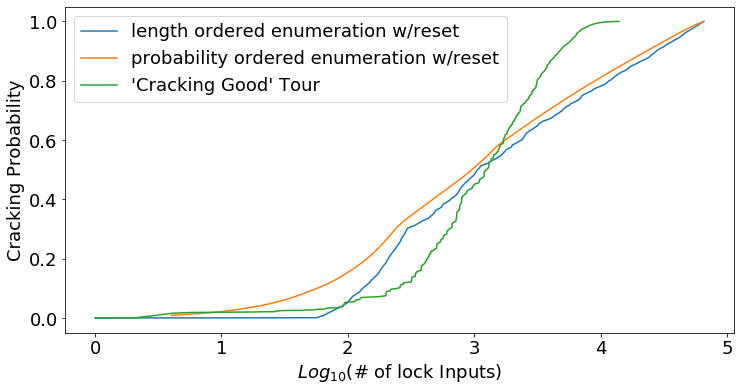

In [265]:
plt.plot(
    np.log10(np.cumsum(access_lengths_ordered)), 
    np.cumsum(associated_probs_ordered), 
    label="length ordered enumeration w/reset"
)
plt.plot(
    np.log10(np.cumsum(access_lengths_mp_first)), 
    np.cumsum(probs_mp_first),
    label="probability ordered enumeration w/reset"
)

plt.plot(
    np.log10(tour_input_count[1:]),
    cumulative_cracking_prob[1:],
    label="'Cracking Good' Tour"
)

plt.xlabel("$Log_{10}$(# of lock Inputs)")
plt.ylabel("Cracking Probability")
plt.legend()

In [279]:
cumulative_cracking_prob[5000]

0.912273290200139

As I mentioned above if you are reasonably sure that your particular lock has a lock state which corresponds to one of the possible length 4 codes (or below) you are probably better off simply checking all 256 such possible codes and resetting in between. Among other things this will make it so that if you screw up one input on one of the codes you still are basically equally likely to sucessfully open the lock since it will not affect your future attempts after the reset. 

But on the other hand if your particular lock has a state which corresponds to some unknown state in the greater universe of possible lock states then you would do well to do away with resets altogether and do a tour of all possible lock states checking the lock to see if it will open after each and every input. After "just" 5,000 5,000 directional inputs you have a 90% probability of having craked the lock and after 14,000 perfect directional inputs you will have completely covered all possible lock states. Quite a savings compared to the 65,000+ directional inputs which are required when resetting in between lock states.

The following set of inputs compltely covers the entire lock space and uses no resets and using my above probability estimate has a 90% chance to have cracked any lock by the 5,000th directional input... In practice a drill or a bolt cutter and a replacement lock is a much more viable strategy. But just in case you are interested here is a set of inputs which completely cover the internal lock state space without resets. In practice it would be far superior to include a small number of resets so that you could redo segments and a single mistake in thousands of inputs didn't completely hose you. Even so here is one possible cracking tour. Please please please do not try to use this to crack an actual lock. I only spent a few tens of minutes writing the tour search code and this is no where near an optimally short tour. Also honestly a collection of a small set of paths including resets would be much more practically effective since you could redo each section between resets without needing to redo the entire sequence or put absolutely every direction in perfectly. However I've been working on this blog post for months at this point and I need to move on. Perhaps if this post accrues some comments asking for a more optimal set of short tours with resets I might consider making the attempt. If you are really serious you can also download this notebook (just replace the .html in the url with .ipynb) and make some tweaks yourself. I would be interested to hear any progress you make. 

In [284]:
tour_directions = [chirality_to_directions[get_chirality(state)][-1] for state in cracking_tour[1:]]

to_arrows(tour_directions)

'🠞🠜🠝🠟🠝🠟🠜🠝🠞🠞🠞🠜🠜🠞🠜🠞🠜🠝🠟🠝🠟🠞🠟🠞🠞🠜🠟🠝🠟🠞🠟🠜🠞🠟🠝🠞🠞🠟🠞🠜🠟🠟🠞🠞🠝🠜🠞🠝🠜🠟🠝🠝🠟🠝🠟🠝🠟🠝🠜🠟🠟🠞🠟🠞🠞🠝🠟🠝🠞🠝🠞🠞🠞🠞🠝🠞🠝🠞🠝🠞🠟🠟🠜🠜🠞🠝🠝🠝🠟🠜🠝🠜🠞🠟🠞🠝🠞🠜🠜🠝🠟🠞🠜🠝🠝🠟🠟🠟🠜🠝🠞🠝🠞🠞🠝🠜🠞🠝🠜🠝🠜🠟🠟🠜🠝🠞🠜🠝🠜🠝🠜🠝🠝🠜🠜🠟🠜🠞🠝🠟🠟🠝🠝🠞🠟🠞🠟🠞🠟🠝🠜🠝🠜🠜🠟🠞🠟🠞🠟🠟🠟🠝🠞🠜🠟🠞🠝🠝🠝🠜🠟🠜🠞🠝🠞🠟🠞🠟🠝🠜🠜🠞🠜🠞🠜🠜🠟🠝🠟🠝🠜🠝🠟🠟🠜🠟🠞🠟🠞🠞🠜🠞🠜🠞🠟🠞🠟🠜🠜🠞🠞🠞🠞🠟🠜🠝🠝🠜🠟🠜🠟🠟🠜🠜🠝🠜🠜🠟🠝🠟🠝🠜🠟🠟🠟🠞🠝🠞🠝🠝🠞🠜🠜🠜🠟🠜🠟🠜🠟🠜🠟🠟🠟🠟🠝🠟🠟🠞🠞🠟🠜🠟🠜🠟🠞🠟🠟🠟🠟🠞🠟🠜🠟🠜🠜🠜🠞🠜🠞🠜🠞🠟🠜🠟🠝🠟🠟🠟🠝🠝🠞🠟🠝🠟🠜🠟🠞🠜🠞🠜🠞🠝🠜🠞🠜🠞🠜🠞🠞🠝🠜🠝🠞🠞🠞🠞🠜🠟🠟🠝🠜🠟🠞🠜🠜🠝🠝🠜🠞🠞🠞🠞🠜🠝🠝🠟🠝🠟🠝🠞🠜🠜🠟🠝🠟🠜🠟🠞🠞🠟🠞🠟🠜🠞🠟🠞🠟🠟🠜🠟🠞🠜🠞🠝🠞🠟🠟🠟🠝🠝🠝🠜🠟🠞🠟🠞🠝🠟🠝🠜🠜🠞🠜🠜🠞🠞🠝🠞🠝🠝🠝🠞🠝🠞🠞🠞🠝🠟🠟🠞🠜🠟🠞🠝🠞🠞🠞🠜🠝🠜🠝🠜🠜🠝🠜🠝🠜🠝🠜🠟🠝🠜🠝🠟🠞🠝🠟🠟🠞🠝🠞🠞🠜🠞🠜🠟🠜🠟🠟🠞🠝🠜🠞🠟🠞🠜🠞🠝🠜🠟🠞🠝🠝🠞🠞🠟🠟🠞🠟🠟🠜🠝🠜🠜🠜🠜🠝🠞🠜🠟🠞🠝🠟🠜🠞🠟🠝🠟🠝🠞🠟🠟🠝🠜🠜🠜🠟🠞🠝🠟🠝🠝🠞🠝🠝🠜🠞🠟🠞🠝🠟🠝🠝🠞🠝🠟🠟🠝🠜🠝🠜🠝🠟🠝🠞🠞🠞🠝🠞🠟🠝🠜🠜🠜🠟🠝🠞🠝🠞🠟🠟🠞🠜🠞🠜🠝🠜🠟🠞🠟🠜🠝🠞🠝🠝🠞🠝🠜🠝🠟🠝🠜🠜🠟🠜🠞🠝🠞🠜🠟🠟🠝🠞🠝🠞🠝🠞🠝🠜🠝🠟🠝🠜🠝🠝🠟🠜🠞🠜🠜🠟🠟🠝🠜🠝🠝🠟🠜🠜🠟🠞🠟🠟🠝🠞🠜🠜🠜🠝🠝🠝🠞🠟🠝🠟🠟🠜🠟🠞🠟🠞🠝🠜🠟🠝🠞🠞🠝🠜🠟🠞🠟🠟🠞🠟🠞🠝🠜🠝🠝🠟🠜🠜🠜🠝🠞🠜🠝🠜🠞🠟🠟🠝🠝🠟🠟🠟🠜🠟🠝🠞🠜🠝🠟🠟🠟🠜🠜🠞🠟🠞🠞🠝🠟🠝🠞🠝🠜🠝🠟🠝🠞🠟🠟🠝🠝🠝🠜🠟🠝🠝🠞🠜🠞🠝🠞🠞🠟🠟🠟🠝🠟🠝🠞🠟🠝🠟🠞🠟🠝🠝🠞🠜🠝🠜🠟🠞🠞🠟🠞🠝🠝🠟🠜🠞🠞🠝🠝🠞🠟🠞🠞🠞🠞🠝🠟🠜🠟🠞🠟🠟🠟🠜🠞🠜🠞🠟🠝🠟🠝🠟🠝🠟🠟🠜🠟🠜🠟🠜🠜🠜🠜🠟🠝🠟🠟🠟🠜🠜🠝🠟🠜🠝🠜🠝🠜🠟🠜🠞🠜🠝🠜🠟🠜🠜🠞🠝🠜🠟🠜🠞🠞🠝🠝🠞🠟🠝🠝🠟🠞🠟🠜🠟🠜🠜🠞🠝🠟🠜🠝🠜🠟🠜🠜🠜🠟🠝🠟🠜🠟🠟🠟🠞🠝🠞🠜🠝🠜🠝🠜🠞🠟🠜🠝🠞🠜🠞🠝🠜🠝🠜🠞🠜🠝🠟🠟🠞🠟🠝🠞🠟🠜🠜🠞🠜🠞🠞🠜🠜🠞🠜🠞🠟🠞🠝🠞🠞🠜🠞🠞🠝🠝🠞🠝🠞🠝🠞🠝🠟🠜🠝🠜🠟🠜🠞🠜🠞🠞🠞🠝🠜🠜🠟🠞🠝🠞🠞🠞🠟🠞🠟🠞🠜🠞🠞🠞🠜🠜🠞🠟🠞🠜🠝🠜🠝🠟🠟🠜🠞🠜🠞🠞🠝🠞🠞🠜🠟🠝🠜🠝🠜🠝🠝🠝🠝🠝🠟🠝🠟🠝🠝🠟🠝🠜🠟🠞🠟🠜🠜🠝🠞🠜🠟🠜🠜🠝🠟🠟🠟🠟🠟🠞🠞🠜🠝🠞🠝🠜🠜🠜🠞🠟🠝🠝🠝🠞🠟🠜🠞🠜🠞🠜🠞🠜🠜🠜🠝🠟🠜🠞🠟🠞🠟🠜🠟🠜🠞🠝🠝🠟🠜🠞🠜🠞🠜🠞🠜🠜🠜